In [3]:
# TỔNG HỢP PHÂN TÍCH MÔ TẢ
# Dataset: Exam_Score_Prediction.csv
import findspark
findspark.init()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, min, max, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression as SklearnLR


#  KHỞI TẠO & CẤU HÌNH
print(">>> KHỞI TẠO SPARK SESSION...")
spark = SparkSession.builder \
    .appName("Descriptive_Analysis_Full") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Đọc dữ liệu bằng PANDAS (Dùng cho thống kê sơ bộ & vẽ biểu đồ nhẹ)
print(">>> ĐỌC DỮ LIỆU (PANDAS)...")
df_pd = pd.read_csv("Exam_Score_Prediction.csv")

# Đọc dữ liệu bằng SPARK (Dùng cho tính toán Big Data & model)
print(">>> ĐỌC DỮ LIỆU (SPARK)...")
df_sp = spark.read.csv("Exam_Score_Prediction.csv", header=True, inferSchema=True)

>>> KHỞI TẠO SPARK SESSION...
>>> ĐỌC DỮ LIỆU (PANDAS)...
>>> ĐỌC DỮ LIỆU (SPARK)...


In [5]:
#  THỐNG KÊ CƠ BẢN & LÀM SẠCH
print("\n" + "=" * 40)
print("THỐNG KÊ CƠ BẢN & LÀM SẠCH")
print("=" * 40)

# Kiểm tra tổng quan
print("\n--- INFO DATASET ---")
df_pd.info()
print("\n--- GIÁ TRỊ THIẾU (NULL) ---")
print(df_pd.isnull().sum())


THỐNG KÊ CƠ BẢN & LÀM SẠCH

--- INFO DATASET ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999997 entries, 0 to 999996
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                999997 non-null  int64  
 1   Grade              999997 non-null  int64  
 2   Gender             999997 non-null  object 
 3   Race               999997 non-null  object 
 4   SES_Quartile       999997 non-null  int64  
 5   ParentalEducation  999997 non-null  object 
 6   SchoolType         999997 non-null  object 
 7   Locale             999997 non-null  object 
 8   TestScore_Math     999997 non-null  float64
 9   TestScore_Reading  999997 non-null  float64
 10  TestScore_Science  999997 non-null  float64
 11  GPA                999997 non-null  float64
 12  AttendanceRate     999997 non-null  float64
 13  StudyHours         999997 non-null  float64
 14  InternetAccess     999997 non-null  int64  
 15  E

In [6]:
# Xử lý trùng lặp
duplicates = df_pd[df_pd.duplicated(keep=False)]
print(f"\n--- SỐ DÒNG TRÙNG LẶP: {duplicates.shape[0]} ---")
if duplicates.shape[0] > 0:
    df_pd = df_pd.drop_duplicates()
    print(f"Đã xóa dòng trùng. Số dòng còn lại: {df_pd.shape[0]}")


--- SỐ DÒNG TRÙNG LẶP: 0 ---


In [7]:
# Thống kê bằng Spark (Cho các cột số)
numeric_cols = [c for c, t in df_sp.dtypes if t in ("int", "double", "float", "bigint")]
df_num_sp = df_sp.select(numeric_cols)

print("\n--- THỐNG KÊ CƠ BẢN (MEAN, STD, MIN, MAX) ---")
df_num_sp.select(*[mean(c).alias(c) for c in numeric_cols]).show()
df_num_sp.select(*[stddev(c).alias(c) for c in numeric_cols]).show()
df_num_sp.select(*[min(c).alias(c) for c in numeric_cols]).show()
df_num_sp.select(*[max(c).alias(c) for c in numeric_cols]).show()


--- THỐNG KÊ CƠ BẢN (MEAN, STD, MIN, MAX) ---
+------------------+------------------+------------------+----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+-------------------+-----------------+------------------+
|               Age|             Grade|      SES_Quartile|  TestScore_Math|TestScore_Reading|TestScore_Science|               GPA|   AttendanceRate|        StudyHours|    InternetAccess|   Extracurricular|        PartTimeJob|    ParentSupport|           Romantic|         FreeTime|             GoOut|
+------------------+------------------+------------------+----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+-------------------+-----------------+------------------+
|15.999192997578993|10.799551398654195|2.500283500


 BIỂU ĐỒ PHÂN PHỐI (HISTOGRAM & BOXPLOT)


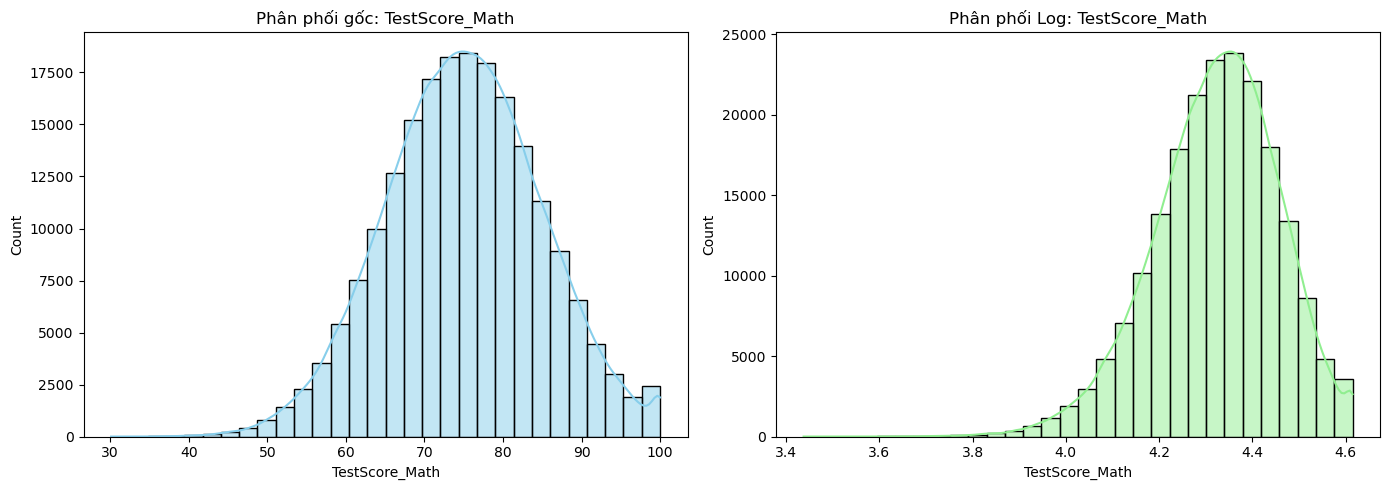

>>> Vẽ Histogram (Countplot) riêng cho cột 'Age'...


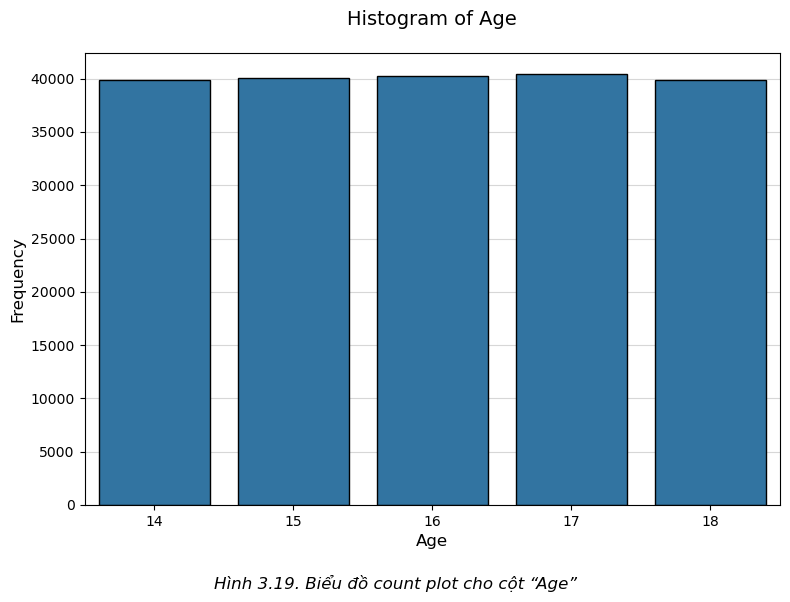

In [8]:
#  BIỂU ĐỒ PHÂN PHỐI (HISTOGRAM & BOXPLOT)
print("\n" + "=" * 40)
print(" BIỂU ĐỒ PHÂN PHỐI (HISTOGRAM & BOXPLOT)")
print("=" * 40)

# Lấy mẫu dữ liệu Spark sang Pandas để vẽ cho nhẹ (20%)
pdf_sample = df_sp.sample(False, 0.2, seed=42).toPandas()

#  Histogram (Phân phối gốc & Log của TestScore_Math)
target_col = "TestScore_Math"
if target_col in pdf_sample.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gốc
    sns.histplot(data=pdf_sample, x=target_col, kde=True, bins=30, color='skyblue', ax=axes[0])
    axes[0].set_title(f'Phân phối gốc: {target_col}')

    # Log Transform
    log_col = np.log1p(pdf_sample[target_col])
    sns.histplot(x=log_col, kde=True, bins=30, color='lightgreen', ax=axes[1])
    axes[1].set_title(f'Phân phối Log: {target_col}')

    plt.tight_layout()
    plt.show()

#  VẼ  COUNTPLOT CHO CỘT "AGE"
if "Age" in pdf_sample.columns:
    print(">>> Vẽ Histogram (Countplot) riêng cho cột 'Age'...")
    plt.figure(figsize=(8, 6))

    # Vẽ biểu đồ cột đếm tần suất
    ax = sns.countplot(data=pdf_sample, x="Age", color='#1f77b4', edgecolor='black')

    plt.title("Histogram of Age", fontsize=14, pad=20)
    plt.xlabel("Age", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    ax.set_axisbelow(True)  # Đưa lưới xuống dưới cột

    # Thêm chú thích phía dưới
    plt.figtext(0.5, 0.01, 'Hình 3.19. Biểu đồ count plot cho cột “Age”',
                ha='center', fontsize=12, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Chừa chỗ cho chú thích
    plt.show()

>>> Vẽ Boxplot tổng quát...


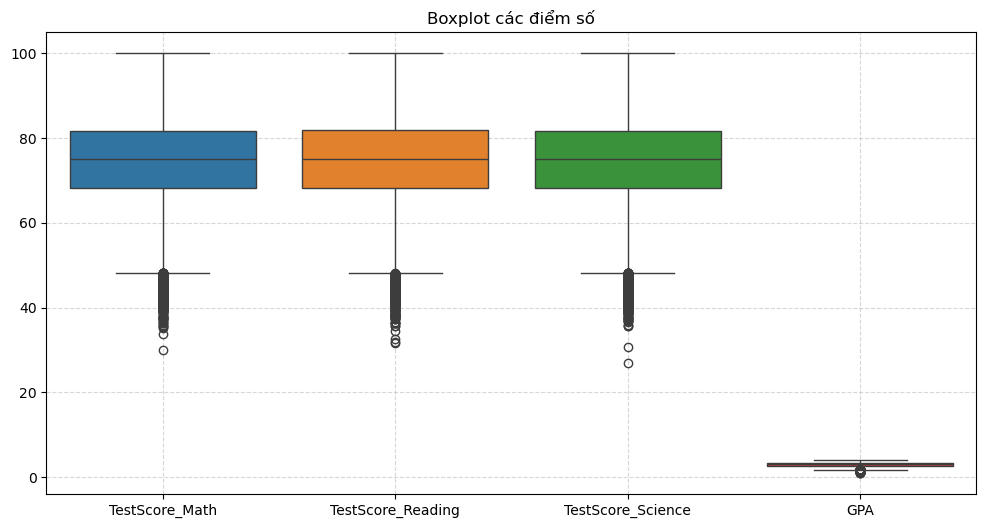

In [9]:
#  Boxplot nhiều cột
print(">>> Vẽ Boxplot tổng quát...")
plt.figure(figsize=(12, 6))
cols_to_plot = ["TestScore_Math", "TestScore_Reading", "TestScore_Science", "GPA"]
if all(c in pdf_sample.columns for c in cols_to_plot):
    sns.boxplot(data=pdf_sample[cols_to_plot])
    plt.title("Boxplot các điểm số")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


TƯƠNG QUAN (JOINTPLOT & SCATTER MATRIX)
>>> Vẽ Jointplot (StudyHours vs Math)...


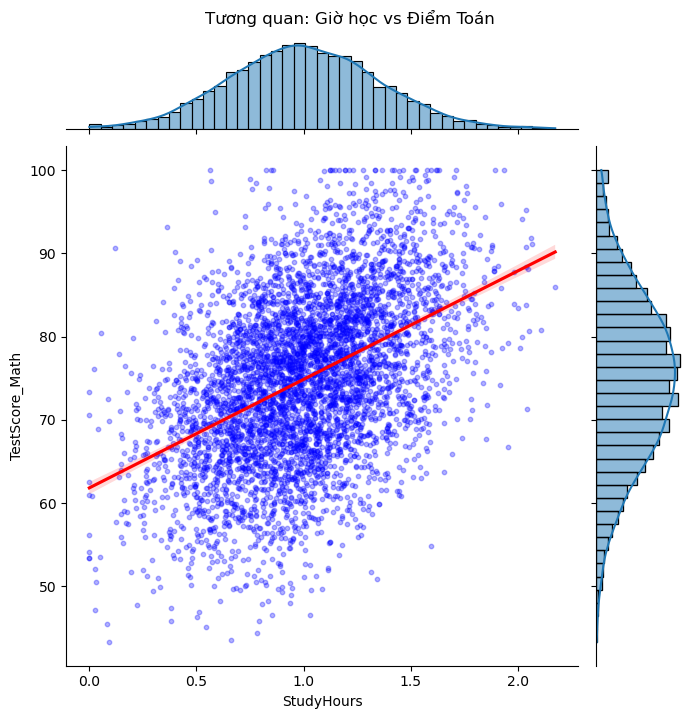

In [10]:
#  TƯƠNG QUAN (JOINTPLOT & SCATTER MATRIX)
print("\n" + "=" * 40)
print("TƯƠNG QUAN (JOINTPLOT & SCATTER MATRIX)")
print("=" * 40)

# Lấy mẫu nhỏ hơn cho scatter plot (tránh treo máy)
df_viz_small = df_pd.sample(n=5000, random_state=42) if len(df_pd) > 5000 else df_pd

# Jointplot (Math Score vs Study Hours)
print(">>> Vẽ Jointplot (StudyHours vs Math)...")
g = sns.jointplot(
    data=df_viz_small,
    x='StudyHours',
    y='TestScore_Math',
    kind='reg',
    height=7,
    scatter_kws={'color': 'blue', 'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'}
)
g.fig.suptitle('Tương quan: Giờ học vs Điểm Toán', y=1.02)
plt.show()


>>> Vẽ Pairplot (Scatter Matrix) - 5 cột đầu...


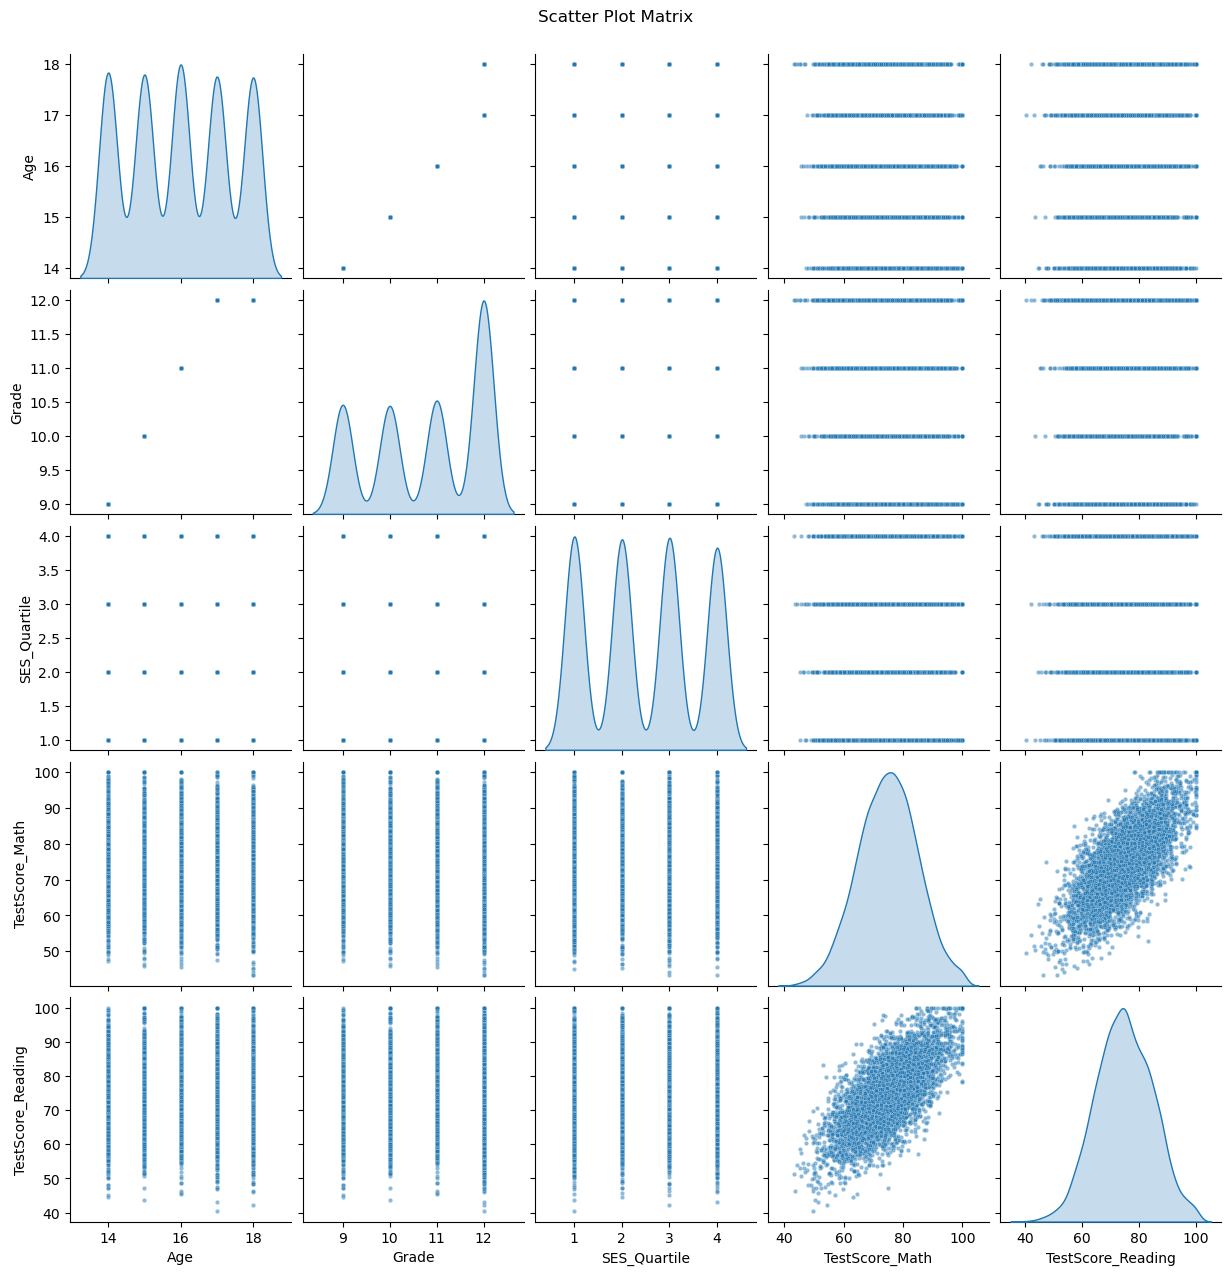

In [11]:
# Scatter Plot Matrix (Pairplot)
print(">>> Vẽ Pairplot (Scatter Matrix) - 5 cột đầu...")
cols_pair = numeric_cols[:5]  # Lấy 5 cột đầu tiên
sns.pairplot(df_viz_small[cols_pair], diag_kind='kde', plot_kws={'s': 10, 'alpha': 0.5})
plt.suptitle("Scatter Plot Matrix", y=1.02)
plt.show()


HEATMAP & VIOLIN PLOT
>>> Vẽ Correlation Heatmap...


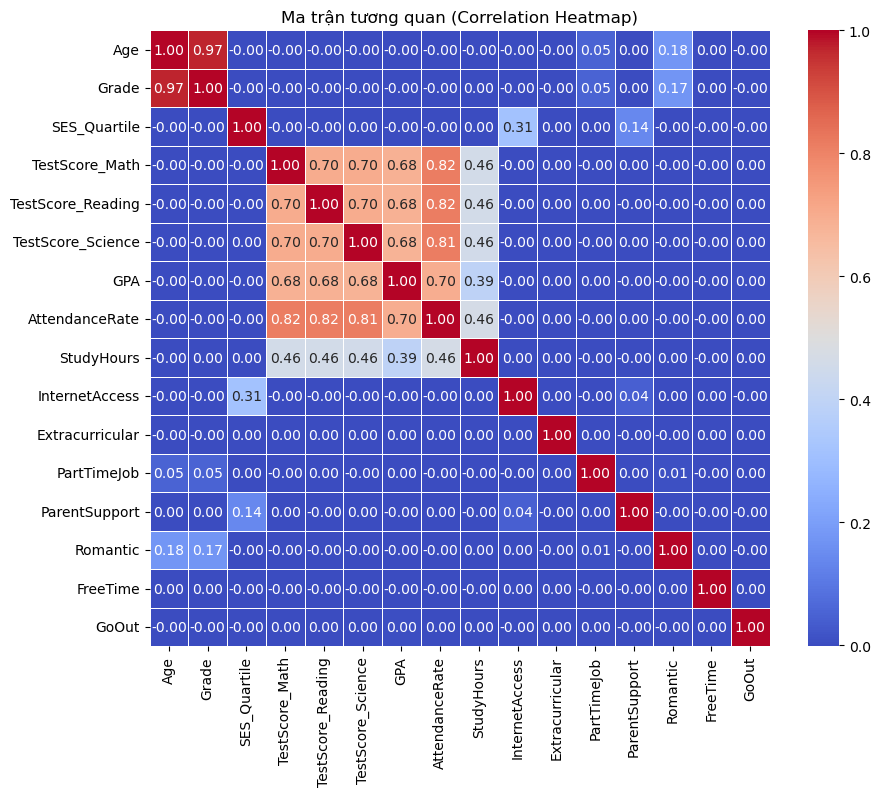

>>> Vẽ Violin Plot (Locale vs Math)...


C:\Users\mylaptop\AppData\Local\Temp\ipykernel_1920\3250670961.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Locale", y="TestScore_Math", data=df_pd, palette="muted")


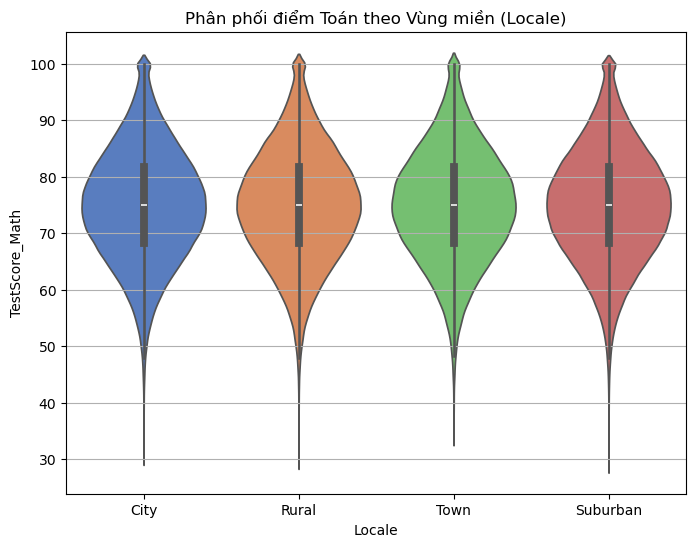

In [12]:
# HEATMAP & VIOLIN PLOT
print("\n" + "=" * 40)
print("HEATMAP & VIOLIN PLOT")
print("=" * 40)

# Heatmap
print(">>> Vẽ Correlation Heatmap...")
corr_matrix = df_pd.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Ma trận tương quan (Correlation Heatmap)")
plt.show()

# Violin Plot (Điểm toán theo Vùng miền - Locale)
if "Locale" in df_pd.columns:
    print(">>> Vẽ Violin Plot (Locale vs Math)...")
    plt.figure(figsize=(8, 6))
    sns.violinplot(x="Locale", y="TestScore_Math", data=df_pd, palette="muted")
    plt.title("Phân phối điểm Toán theo Vùng miền (Locale)")
    plt.grid(True, axis='y')
    plt.show()


 BIỂU ĐỒ LEARNING CURVE


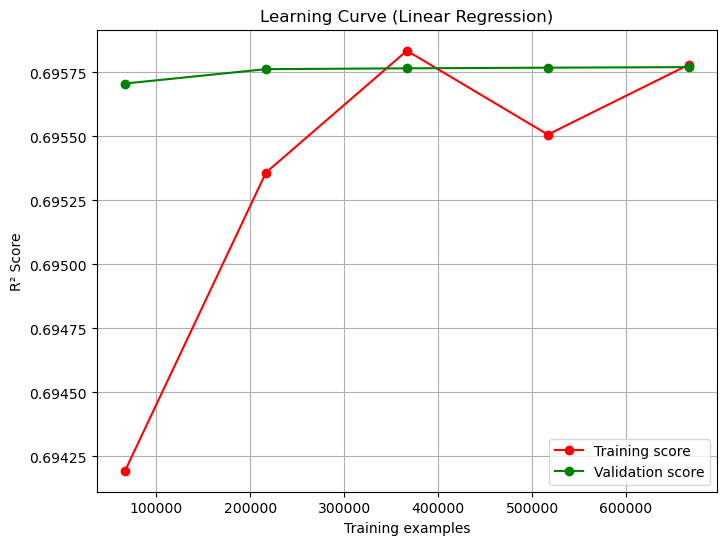

In [14]:
# BIỂU ĐỒ LEARNING CURVE
print("\n" + "=" * 40)
print(" BIỂU ĐỒ LEARNING CURVE")
print("=" * 40)

# Chuẩn bị dữ liệu cho Sklearn
df_clean = df_pd.select_dtypes(include=[np.number]).dropna()
X_lc = df_clean.drop(columns=["TestScore_Math"])
y_lc = df_clean["TestScore_Math"]

# Tính toán Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    SklearnLR(), X_lc, y_lc, cv=3, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)  # 5 điểm chia để chạy nhanh
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation score")
plt.title("Learning Curve (Linear Regression)")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


 RESIDUALS & FEATURE IMPORTANCE (SPARK MODEL)
>>> Vẽ Residual Plots...


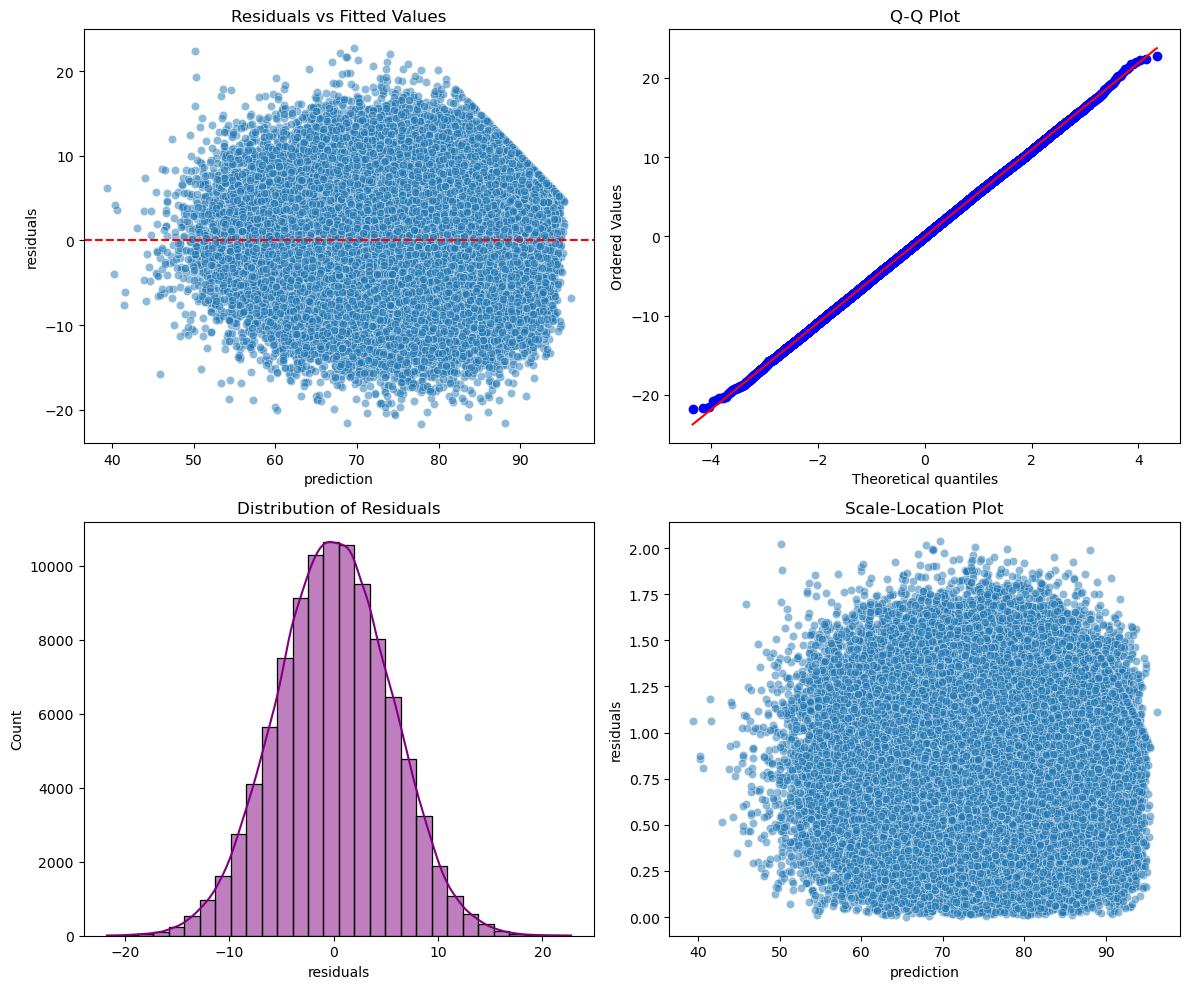

In [15]:
# RESIDUALS & FEATURE IMPORTANCE (SPARK MODEL)
print("\n" + "=" * 40)
print(" RESIDUALS & FEATURE IMPORTANCE (SPARK MODEL)")
print("=" * 40)

# Huấn luyện model Spark để lấy thông số
input_cols = [c for c in numeric_cols if c != target_col]
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
df_transformed = assembler.transform(df_sp.dropna())

lr_spark = LinearRegression(featuresCol="features", labelCol=target_col)
lr_model = lr_spark.fit(df_transformed)

# Vẽ Residual Plots
print(">>> Vẽ Residual Plots...")
predictions = lr_model.transform(df_transformed)
# Lấy mẫu kết quả để vẽ
pdf_resid = predictions.select(target_col, "prediction").sample(False, 0.1, seed=42).toPandas()
pdf_resid['residuals'] = pdf_resid[target_col] - pdf_resid['prediction']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residuals vs Fitted
sns.scatterplot(x=pdf_resid['prediction'], y=pdf_resid['residuals'], ax=axes[0, 0], alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals vs Fitted Values')

# Q-Q Plot
stats.probplot(pdf_resid['residuals'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')

# Distribution
sns.histplot(pdf_resid['residuals'], bins=30, kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Distribution of Residuals')

# Scale-Location
std_resid = (pdf_resid['residuals'] - pdf_resid['residuals'].mean()) / pdf_resid['residuals'].std()
sns.scatterplot(x=pdf_resid['prediction'], y=np.sqrt(np.abs(std_resid)), ax=axes[1, 1], alpha=0.5)
axes[1, 1].set_title('Scale-Location Plot')

plt.tight_layout()
plt.show()

>>> Vẽ Feature Importance...


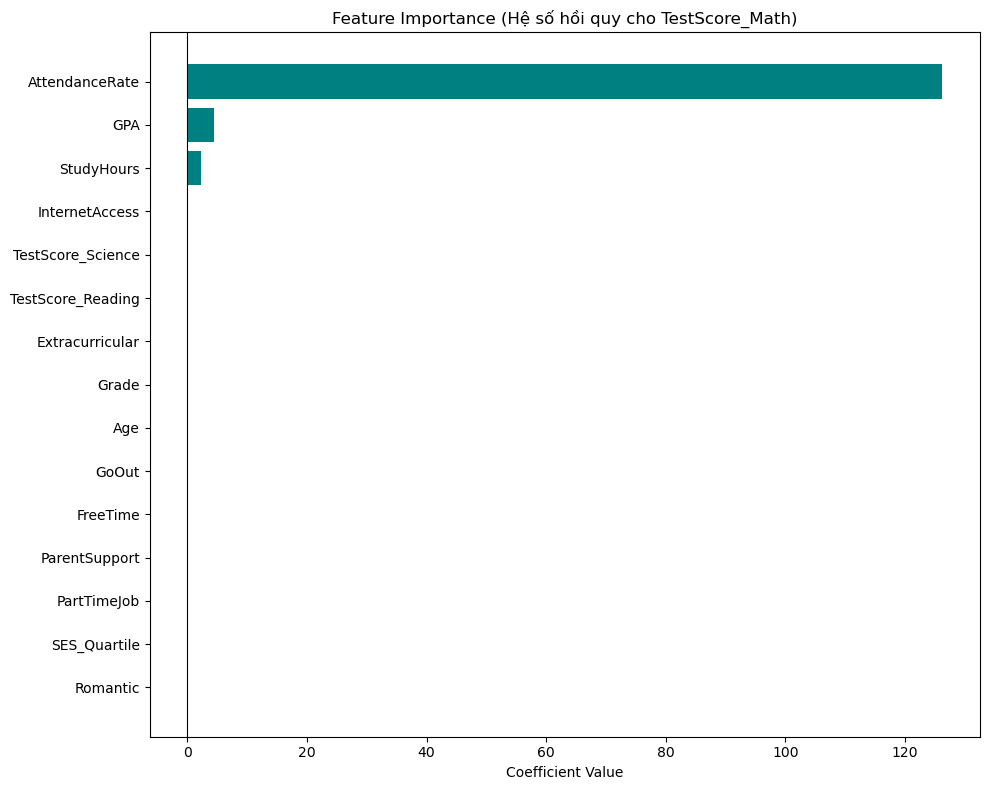


ĐÃ HOÀN THÀNH TOÀN BỘ PHÂN TÍCH!


In [16]:
# Feature Importance
print(">>> Vẽ Feature Importance...")
coeffs = lr_model.coefficients.toArray()
coeff_df = pd.DataFrame({'Feature': input_cols, 'Coefficient': coeffs})
coeff_df = coeff_df.sort_values(by='Coefficient', key=abs, ascending=True)  # Sắp xếp theo độ lớn tuyệt đối

plt.figure(figsize=(10, 8))
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'], color='teal')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.title(f'Feature Importance (Hệ số hồi quy cho {target_col})')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

# KẾT THÚC
spark.stop()
print("\nĐÃ HOÀN THÀNH TOÀN BỘ PHÂN TÍCH!")